In [61]:
from utils import load_spam_dataset

df_train, df_valid, df_test = load_spam_dataset()

In [62]:
df_valid.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,LABEL,VIDEO_ID
344,_2viQ_Qnc68ki9xsFeN2y1_ZiHYcZC8Qv1GyHfwqr7Y,steven reed,2013-07-19T22:12:16.609000,Please check out and send to others Freedom an...,1,5
7,z12uujnj2sifvzvav04chpypvofvexpoggg,Sudheer Yadav,2015-05-28T10:28:25.133000,SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakir...,1,5
122,z12uftdyclu0s1mbc04cffvjlrukxpl5zdg,Napoleon Maldia,2015-05-21T01:53:33.012000,Cutie girl and beautiful song,2,5
365,_2viQ_Qnc6-bMSjqyL1NKj57ROicCSJV5SwTrw-RFFA,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,2,5
318,_2viQ_Qnc6870xv47G-__kc0IimrvnGFcLXaLnJsiFE,Edward Wright,2013-08-11T05:23:08.533000,"Hey, hit this shit up while yall can, they kil...",1,5


### Test end model quality

In [63]:
# from ludwig.api import LudwigModel

# df_train['LABEL'] = df_train['LABEL'].map({1: 1, 2: 0})
# df_valid['LABEL'] = df_valid['LABEL'].map({1: 1, 2: 0})
# df_test['LABEL'] = df_test['LABEL'].map({1: 1, 2: 0})

In [64]:
# model_definition = {
#     "input_features": [{"name": "CONTENT", "type": "text"}], 
#     "output_features": [{"name": "LABEL", "type": "binary"}],
#     "training": {"epochs": 1},
# }
# model = LudwigModel(model_definition)
# train_stats = model.train(
#     data_train_df=df_train, 
#     data_validation_df=df_valid, 
#     data_test_df=df_test, 
#     logging_level=20,
#     epochs=4,
# )
# train_stats

### Test LF ideas

In [65]:
from snorkel.labeling.lf import labeling_function

lfs = []

@labeling_function()
def lf_subscribe(x):
    return 1 if "subscribe" in x.CONTENT else 0
lfs.append(lf_subscribe)

@labeling_function()
def lf_check_out(x):
    return 1 if "check" in x.CONTENT.lower() and "out" in x.CONTENT.lower() else 0
lfs.append(lf_check_out)

@labeling_function()
def lf_my(x):
    return 1 if "my" in x.CONTENT.lower() else 0
lfs.append(lf_my)

@labeling_function()
def lf_link(x):
    return 1 if "http" in x.CONTENT.lower() else 0
lfs.append(lf_link)

@labeling_function()
def lf_please(x):
    return 1 if "please" in x.CONTENT.lower() else 0
lfs.append(lf_please)

@labeling_function()
def lf_come(x):
    return 1 if "come" in x.CONTENT.lower() else 0
lfs.append(lf_come)

@labeling_function()
def lf_song(x):
    return 2 if "song" in x.CONTENT.lower() else 0
lfs.append(lf_song)

@labeling_function()
def lf_short(x):
    return 2 if len(x.CONTENT.split()) < 5 else 0
lfs.append(lf_short)


In [66]:
from snorkel.labeling.apply import PandasLFApplier

applier = PandasLFApplier(lfs)
L_valid = applier.apply(df_valid)
L_train = applier.apply(df_train)

100%|██████████| 1586/1586 [00:00<00:00, 7413.57it/s]


In [67]:
from snorkel.analysis.utils import convert_labels
from snorkel.labeling.analysis import lf_summary

Y_valid = convert_labels(df_valid.LABEL.values, "onezero", "categorical")
lf_names= [lf.name for lf in lfs]
lf_summary(L_valid, Y_valid, lf_names=lf_names)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_subscribe,0,[1],0.070270,0.043243,0.005405,13,0,1.000000
lf_check_out,1,[1],0.205405,0.108108,0.032432,38,0,1.000000
lf_my,2,[1],0.162162,0.145946,0.064865,26,4,0.866667
lf_link,3,[1],0.027027,0.005405,0.005405,5,0,1.000000
lf_please,4,[1],0.075676,0.059459,0.021622,14,0,1.000000
lf_come,5,[1],0.032432,0.010811,0.005405,5,1,0.833333
lf_song,6,[2],0.275676,0.172973,0.075676,38,13,0.745098
lf_short,7,[2],0.351351,0.108108,0.010811,60,5,0.923077


(array([0.27427491, 0.44010088, 0.19230769, 0.06746532, 0.01954603,
        0.00630517, 0.        ]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

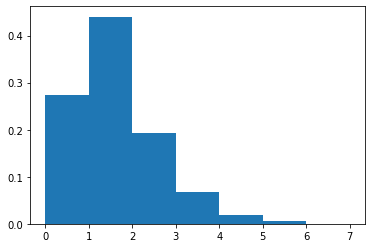

In [68]:
import matplotlib.pyplot as plt
# View label frequency
plt.hist(np.asarray((L_train != 0).sum(axis=1)), density=True, bins=range(len(lfs)))

([array([4.43243243, 0.        , 0.        , 0.        , 0.        ,
         2.27027027, 0.        , 0.        , 0.        , 3.2972973 ]),
  array([4.7027027, 0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 5.2972973])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 Lists of Patches objects>)

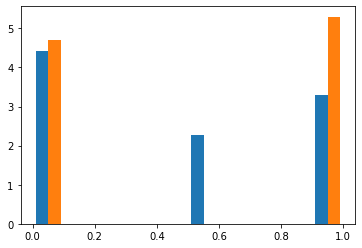

In [102]:
# View probabilities distribution
plt.hist(np.stack((Y_probs_valid[:, 0], Y_valid-1), axis=1), density=True)

In [98]:
Y_probs_valid.shape

(185, 2)

In [69]:
from snorkel.labeling.model import LabelModel

L_train = applier.apply(df_train)
label_model = LabelModel(k=2, verbose=True)
label_model.train_model(L_train)

100%|██████████| 1586/1586 [00:00<00:00, 8100.72it/s]


Could not find kwarg "k" in destination dict.
Computing O...
Estimating \mu...
[1 epochs]: TRAIN:[loss=0.118]
[1 epochs]: TRAIN:[loss=0.116]
[1 epochs]: TRAIN:[loss=0.112]
[1 epochs]: TRAIN:[loss=0.107]
[1 epochs]: TRAIN:[loss=0.100]
[1 epochs]: TRAIN:[loss=0.092]
[1 epochs]: TRAIN:[loss=0.084]
[1 epochs]: TRAIN:[loss=0.075]
[1 epochs]: TRAIN:[loss=0.067]
[1 epochs]: TRAIN:[loss=0.058]
[1 epochs]: TRAIN:[loss=0.050]
[1 epochs]: TRAIN:[loss=0.043]
[1 epochs]: TRAIN:[loss=0.036]
[1 epochs]: TRAIN:[loss=0.030]
[1 epochs]: TRAIN:[loss=0.025]
[1 epochs]: TRAIN:[loss=0.022]
[1 epochs]: TRAIN:[loss=0.019]
[1 epochs]: TRAIN:[loss=0.016]
[1 epochs]: TRAIN:[loss=0.015]
[1 epochs]: TRAIN:[loss=0.015]
[1 epochs]: TRAIN:[loss=0.014]
[1 epochs]: TRAIN:[loss=0.015]
[1 epochs]: TRAIN:[loss=0.015]
[1 epochs]: TRAIN:[loss=0.016]
[1 epochs]: TRAIN:[loss=0.017]
[1 epochs]: TRAIN:[loss=0.017]
[1 epochs]: TRAIN:[loss=0.018]
[1 epochs]: TRAIN:[loss=0.018]
[1 epochs]: TRAIN:[loss=0.018]
[1 epochs]: TRAIN:[los

In [94]:
from snorkel.analysis.metrics import metric_score
from snorkel.analysis.utils import probs_to_preds

Y_probs_valid = label_model.predict_proba(L_valid.todense())
Y_preds_valid = probs_to_preds(Y_probs_valid)
metric_score(Y_valid, Y_preds_valid, probs=None, metric="accuracy")

0.827027027027027

In [96]:
from snorkel.analysis.error_analysis import confusion_matrix
confusion_matrix(Y_valid, Y_preds_valid)

        y=1   
 l=1    76    


array([[81, 22],
       [ 6, 76]])

### Compare MV

In [95]:
from snorkel.labeling.model import MajorityLabelVoter

mv_model = MajorityLabelVoter()
Y_probs_valid = mv_model.predict_proba(L_valid.todense())
Y_preds_valid = probs_to_preds(Y_probs_valid)
metric_score(Y_valid, Y_preds_valid, probs=None, metric="accuracy")

0.8486486486486486

### Ludwig with Weak Labels (Rounded)

In [72]:
# Don't train on examples with no labels
mask = L_train.sum(axis=1) > 0
L_train_filtered = L_train[mask.nonzero()[0], :]
df_train_filtered = df_train[mask]

In [73]:
Y_probs_train = label_model.predict_proba(L_train_filtered.todense())
Y_preds_train = probs_to_preds(Y_probs_train)

In [74]:
df_train_filtered['LABEL'] = convert_labels(Y_preds_train, "categorical", "onezero")
df_valid['LABEL'] = df_valid['LABEL'].map({1: 1, 2: 0})
df_test['LABEL'] = df_test['LABEL'].map({1: 1, 2: 0})

/Users/braden/repos/snorkel-tutorials/.env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [75]:
from ludwig.api import LudwigModel

model_definition = {
    "input_features": [{"name": "CONTENT", "type": "text"}], 
    "output_features": [{"name": "LABEL", "type": "binary"}],
    "training": {"epochs": 6},
}
model = LudwigModel(model_definition)

train_stats = model.train(
    data_train_df=df_train_filtered, 
    data_validation_df=df_valid, 
    data_test_df=df_test, 
    logging_level=20,
)
train_stats


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



INFO:root:Experiment name: api_experiment
INFO:root:Model name: run
INFO:root:Output path: results/api_experiment_run_11
INFO:root:

INFO:root:ludwig_version: '0.1.2'
INFO:root:command: ('/Users/braden/repos/snorkel-tutorials/.env/lib/python3.7/site-packages/ipykernel_launcher.py '
 '-f '
 '/Users/braden/Library/Jupyter/runtime/kernel-68dacc71-4c5a-4900-bfa1-0dcf7733be7d.json')
INFO:root:commit_hash: '79f404432df9'
INFO:root:random_seed: 42
INFO:root:model_definition: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'encoder': 'parallel_cnn',
                              'level': 'word',
                              'name': 'CONTENT',
                              'tied_weights': None,
                              'type': 'text'}],
    'output_features': [   {   'dependencies': [],
                               'loss': {   'confidence_penalty': 0,
                                           'robust_lambda': 0,
                                           'threshold': 

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:root:
INFO:root:╒══════════╕
INFO:root:│ TRAINING │
INFO:root:╘══════════╛
INFO:root:
INFO:root:
Epoch 1


Evaluation test : 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

INFO:root:Took 34.8671s
INFO:root:╒═════════╤════════╤════════════╕
│ LABEL   │   loss │   accuracy │
╞═════════╪════════╪════════════╡
│ train   │ 0.4504 │     0.7889 │
├─────────┼────────┼────────────┤
│ vali    │ 0.5717 │     0.6432 │
├─────────┼────────┼────────────┤
│ test    │ 0.6001 │     0.6811 │
╘═════════╧════════╧════════════╛


INFO:root:Validation loss on combined improved, model saved
INFO:root:
INFO:root:
Epoch 2


Evaluation test : 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

INFO:root:Took 35.1287s
INFO:root:╒═════════╤════════╤════════════╕
│ LABEL   │   loss │   accuracy │
╞═════════╪════════╪════════════╡
│ train   │ 0.2251 │     0.8931 │
├─────────┼────────┼────────────┤
│ vali    │ 0.4085 │     0.7676 │
├─────────┼────────┼────────────┤
│ test    │ 0.5052 │     0.6865 │
╘═════════╧════════╧════════════╛


INFO:root:Validation loss on combined improved, model saved
INFO:root:
INFO:root:
Epoch 3


Evaluation test : 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

INFO:root:Took 34.2630s
INFO:root:╒═════════╤════════╤════════════╕
│ LABEL   │   loss │   accuracy │
╞═════════╪════════╪════════════╡
│ train   │ 0.1030 │     0.9626 │
├─────────┼────────┼────────────┤
│ vali    │ 0.3033 │     0.8162 │
├─────────┼────────┼────────────┤
│ test    │ 0.3607 │     0.7946 │
╘═════════╧════════╧════════════╛
INFO:root:Validation loss on combined improved, model saved


INFO:root:
INFO:root:
Epoch 4


Evaluation test : 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

INFO:root:Took 33.6828s
INFO:root:╒═════════╤════════╤════════════╕
│ LABEL   │   loss │   accuracy │
╞═════════╪════════╪════════════╡
│ train   │ 0.0526 │     0.9878 │
├─────────┼────────┼────────────┤
│ vali    │ 0.2689 │     0.8757 │
├─────────┼────────┼────────────┤
│ test    │ 0.3114 │     0.8757 │
╘═════════╧════════╧════════════╛
INFO:root:Validation loss on combined improved, model saved


INFO:root:
INFO:root:
Epoch 5


Evaluation test : 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

INFO:root:Took 33.5693s
INFO:root:╒═════════╤════════╤════════════╕
│ LABEL   │   loss │   accuracy │
╞═════════╪════════╪════════════╡
│ train   │ 0.0441 │     0.9878 │
├─────────┼────────┼────────────┤
│ vali    │ 0.3233 │     0.8757 │
├─────────┼────────┼────────────┤
│ test    │ 0.3776 │     0.8541 │
╘═════════╧════════╧════════════╛
INFO:root:Last improvement of loss on combined happened 1 epoch ago
INFO:root:


INFO:root:Best validation model epoch:
INFO:root:Best validation model loss on validation set combined: 0.2688554815343908
INFO:root:Best validation model loss on test set combined: 0.3113903870453706
INFO:root:
Finished: api_experiment_run
INFO:root:Saved to: results/api_experiment_run_11


{'train': OrderedDict([('LABEL',
               OrderedDict([('loss',
                             [0.4503555960700783,
                              0.2251228776628509,
                              0.10303753754245416,
                              0.052648514483308505,
                              0.04406286984500835]),
                            ('accuracy',
                             [0.788879235447437,
                              0.893136403127715,
                              0.9626411815812337,
                              0.9878366637706343,
                              0.9878366637706343])])),
              ('combined',
               {'loss': [0.4503555960700783,
                 0.2251228776628509,
                 0.10303753754245416,
                 0.052648514483308505,
                 0.04406286984500835],
                'accuracy': [0.788879235447437,
                 0.893136403127715,
                 0.9626411815812337,
                 0.987836663770634

In [92]:
Y_preds_valid = convert_labels(model.predict(df_valid).LABEL_predictions.values.astype(int), "onezero", "categorical")
metric_score(Y_valid, Y_preds_valid, probs=None, metric="accuracy")

0.8756756756756757

In [76]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.
